In [64]:
import requests
import json
import pandas as pd

def _get_ads(url_for_search, params):
    headers = {"accept": "application/json"}
    response = requests.get(url_for_search, headers=headers, params=params)
    response.raise_for_status()
    return json.loads(response.content.decode("utf8"))

# Occupation field ID
occupation_fields = {
    "Försäljning, inköp, marknadsföring": "RPTn_bxG_ExZ",
    "Hälso- och sjukvård": "NYW6_mP6_vwf",
    "Hotell, restaurang, storhushåll": "ScKy_FHB_7wT"
}

url = "https://jobsearch.api.jobtechdev.se/search"

all_ads = []
for field_name, field_id in occupation_fields.items():
    params = {"occupation-field": field_id, "limit": 100, "offset": 0}
    data = _get_ads(url, params)
    hits = data.get("hits", [])
    for h in hits:
        h["occupation_field_name"] = field_name
    all_ads.extend(hits)

df = pd.DataFrame(all_ads)

print("Antal rader och kolumner:", df.shape)
print(df.head(2))


Antal rader och kolumner: (300, 38)
   relevance        id          external_id original_id label  \
0        1.0  30009996  46-556132-1752-3135        None    []   
1        1.0  30009964                 None        None    []   

                                         webpage_url  \
0  https://arbetsformedlingen.se/platsbanken/anno...   
1  https://arbetsformedlingen.se/platsbanken/anno...   

                                            logo_url  \
0                                               None   
1  https://arbetsformedlingen.se/rest/agas/api/v1...   

                             headline application_deadline  \
0       Account Manager – Hälsingland  2025-10-02T23:59:59   
1  Extrajobb som Merchandiser - Piteå  2025-10-05T23:59:59   

   number_of_vacancies  ...  \
0                  1.0  ...   
1                  1.0  ...   

                                           must_have  \
0  {'skills': [], 'languages': [], 'work_experien...   
1  {'skills': [], 'languages': [{'wei

In [65]:
def extract_field(series, key):
    return series.dropna().apply(lambda x: x.get(key) if isinstance(x, dict) else None)

df["municipality"] = extract_field(df["workplace_address"], "municipality")
df["employer_name"] = extract_field(df["employer"], "name")
df["occupation_label"] = extract_field(df["occupation"], "label")
df["employment_label"] = extract_field(df["employment_type"], "label")

print("Nya kolumner:", ["municipality", "employer_name", "occupation_label", "employment_label"])
print(df[["municipality", "employer_name", "occupation_label", "employment_label"]].head(3))


Nya kolumner: ['municipality', 'employer_name', 'occupation_label', 'employment_label']
  municipality                employer_name  \
0        Gävle           Stena Recycling AB   
1        Piteå               Srb Gruppen AB   
2     Göteborg  Made for Business Nordic AB   

                                    occupation_label    employment_label  
0                                 Account manager/AM  Vanlig anställning  
1  Butikssäljare, dagligvaror/Medarbetare, daglig...   Behovsanställning  
2                                         Utesäljare  Vanlig anställning  


In [66]:
kpi_total_ads = df.groupby("occupation_field_name").size()
print("Totalt antal annonser per occupational field:\n", kpi_total_ads)


Totalt antal annonser per occupational field:
 occupation_field_name
Försäljning, inköp, marknadsföring    100
Hotell, restaurang, storhushåll       100
Hälso- och sjukvård                   100
dtype: int64


In [67]:
kpi_top_cities = df["municipality"].value_counts().head(10)
print("Topp 10 kommuner med flest annonser:\n", kpi_top_cities)


Topp 10 kommuner med flest annonser:
 municipality
Stockholm      40
Göteborg       29
Malmö           9
Solna           8
Linköping       8
Helsingborg     8
Norrköping      6
Trollhättan     5
Boden           5
Luleå           5
Name: count, dtype: int64


In [68]:
kpi_top_titles = df["headline"].value_counts().head(10)
print("Vanligaste yrkestitlar:\n", kpi_top_titles)


Vanligaste yrkestitlar:
 headline
Sjuksköterska sökes till SÄBO start omgående                                   6
Regionsansvarig Kökssäljare                                                    3
Sjuksköterska                                                                  2
Boendepersonal till Mårdstigens gruppboende                                    2
Service på restaurangen                                                        2
Kock                                                                           2
Pizzabagare                                                                    2
Administratör till tillverkande företag i Finspång                             2
Medica Nord söker sjuksköterska till Norrköping                                1
Farmaceut till Kronans Apotek Sickla Curanten - Nytt, vårdnära och bekväma     1
Name: count, dtype: int64


In [69]:
kpi_employment_type = df["employment_label"].value_counts(normalize=True) * 100
print("Fördelning av anställningsformer (%):\n", kpi_employment_type)


Fördelning av anställningsformer (%):
 employment_label
Vanlig anställning        94.666667
Behovsanställning          4.666667
Arbete utomlands           0.333333
Sommarjobb / feriejobb     0.333333
Name: proportion, dtype: float64


In [70]:
kpi_unique_employers = df["employer_name"].nunique()
print("Antal unika arbetsgivare:", kpi_unique_employers)


Antal unika arbetsgivare: 194


In [71]:
if "publication_date" in df.columns:
    df["publication_date"] = pd.to_datetime(df["publication_date"], errors="coerce")
    kpi_avg_age_days = (pd.Timestamp.today() - df["publication_date"]).dt.days.mean()
    print("Genomsnittlig annonsålder (dagar):", round(kpi_avg_age_days, 1))


Genomsnittlig annonsålder (dagar): 0.0


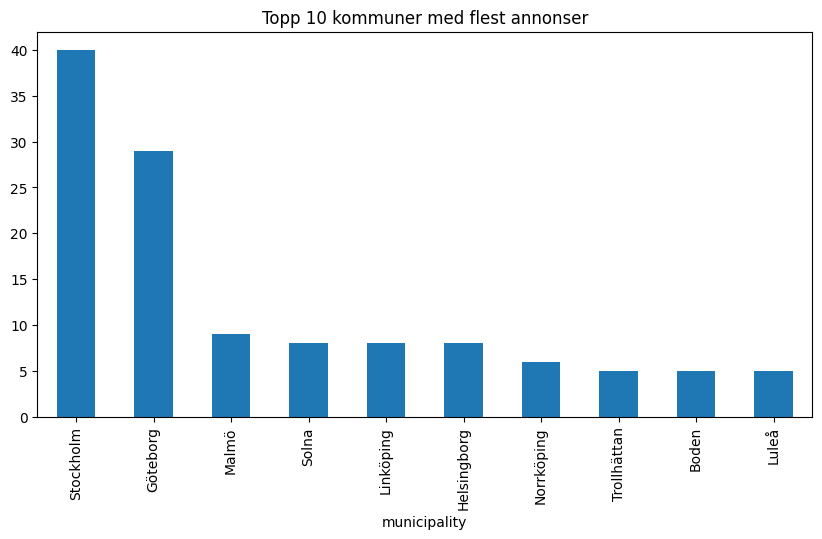

In [72]:
import matplotlib.pyplot as plt

top_cities = df["municipality"].value_counts().head(10)
top_cities.plot(kind="bar", figsize=(10,5), title="Topp 10 kommuner med flest annonser")
plt.show()



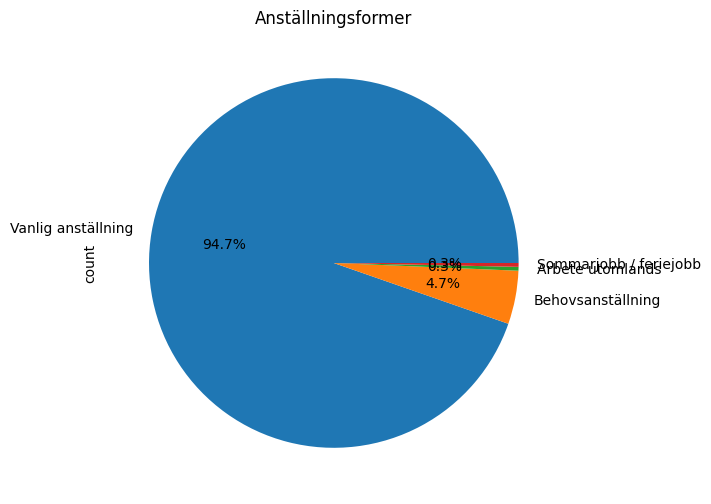

In [73]:
df["employment_label"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(6,6), title="Anställningsformer"
)
plt.show()